# Connect Google Drive and untar data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf "/content/drive/MyDrive/Assignment2 data/train_and_val_set.tar"

In [ ]:
!tar -xvf "/content/drive/MyDrive/Assignment2 data/test_set.tar"

# Data Handling and Loading

In [ ]:
import glob,os
import numpy as np
train_val_path = '/content/train_set/'

data_train_val = []
        
for anno in glob.glob(train_val_path + 'images/*.jpg'):
  idx = os.path.basename(anno).split('.')[0]
  img_path = os.path.join(train_val_path,f'images/{idx}.jpg')
  label = int(np.load(train_val_path + 'annotations/' + idx + '_exp.npy'))
  valence = float(np.load(train_val_path + 'annotations/' + idx + '_val.npy'))
  arousal = float(np.load(train_val_path + 'annotations/' + idx + '_aro.npy'))
  data_train_val.append([img_path,label,valence,arousal])

In [ ]:
import pandas as pd
train_val_df = pd.DataFrame(data = data_train_val,columns = ['img_path','label','valence','arousal'])

In [ ]:
train_val_df.head()

,img_path,label,valence,arousal
0,/content/train_set/images/66446.jpg,1,0.587302,0.015873
1,/content/train_set/images/303821.jpg,0,-0.006614,0.013227
2,/content/train_set/images/341129.jpg,6,-0.716991,0.480249
3,/content/train_set/images/150912.jpg,1,0.883675,0.226860
4,/content/train_set/images/196701.jpg,1,0.492063,-0.039683


In [ ]:
for i in range(8):
  dir_path = 'train/' + str(i)
  os.makedirs(dir_path)

In [ ]:
import shutil
for i in range(8):
  for c in list(train_val_df[train_val_df['label']== i]['img_path']):
    get_image = os.path.join('/content/train_set/images/', c)
    move_image = shutil.copy(get_image, '/content/train/' + str(i))

In [ ]:
import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train/',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=200,
    image_size=(224,224)
)

Found 287651 files belonging to 8 classes.


In [ ]:
test_path = '/content/val_set/'

data_test = []
        
for anno in glob.glob(test_path + 'images/*.jpg'):
  idx = os.path.basename(anno).split('.')[0]
  img_path = os.path.join(test_path,f'images/{idx}.jpg')
  label = int(np.load(test_path + 'annotations/' + idx + '_exp.npy'))
  valence = float(np.load(test_path + 'annotations/' + idx + '_val.npy'))
  arousal = float(np.load(test_path + 'annotations/' + idx + '_aro.npy'))
  data_test.append([img_path,label,valence,arousal])

test_df = pd.DataFrame(data = data_test,columns = ['img_path','label','valence','arousal'])
for i in range(8):
  dir_path = 'test/' + str(i)
  os.makedirs(dir_path)

for i in range(8):
  for c in list(test_df[test_df['label']== i]['img_path']):
    get_image = os.path.join('/content/val_set/images/', c)
    move_image = shutil.copy(get_image, '/content/test/' + str(i))


val_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test/',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=200,
    image_size=(224,224)
)

Found 3999 files belonging to 8 classes.


In [ ]:
import tensorflow as tf
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

# Custom Model

In [ ]:
model = Sequential([

  Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(224,224,3)),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

  Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

  Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

  Conv2D(128,kernel_size=(5,5),padding='valid',activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(4,4),strides=2,padding='valid'),

  Conv2D(64,kernel_size=(7,7),padding='valid',activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(4,4),strides=2,padding='valid'),

  Flatten(),

  Dense(128,activation='relu'),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.3),
  Dense(units = 8,activation='softmax')
])

# Model Visualiztion

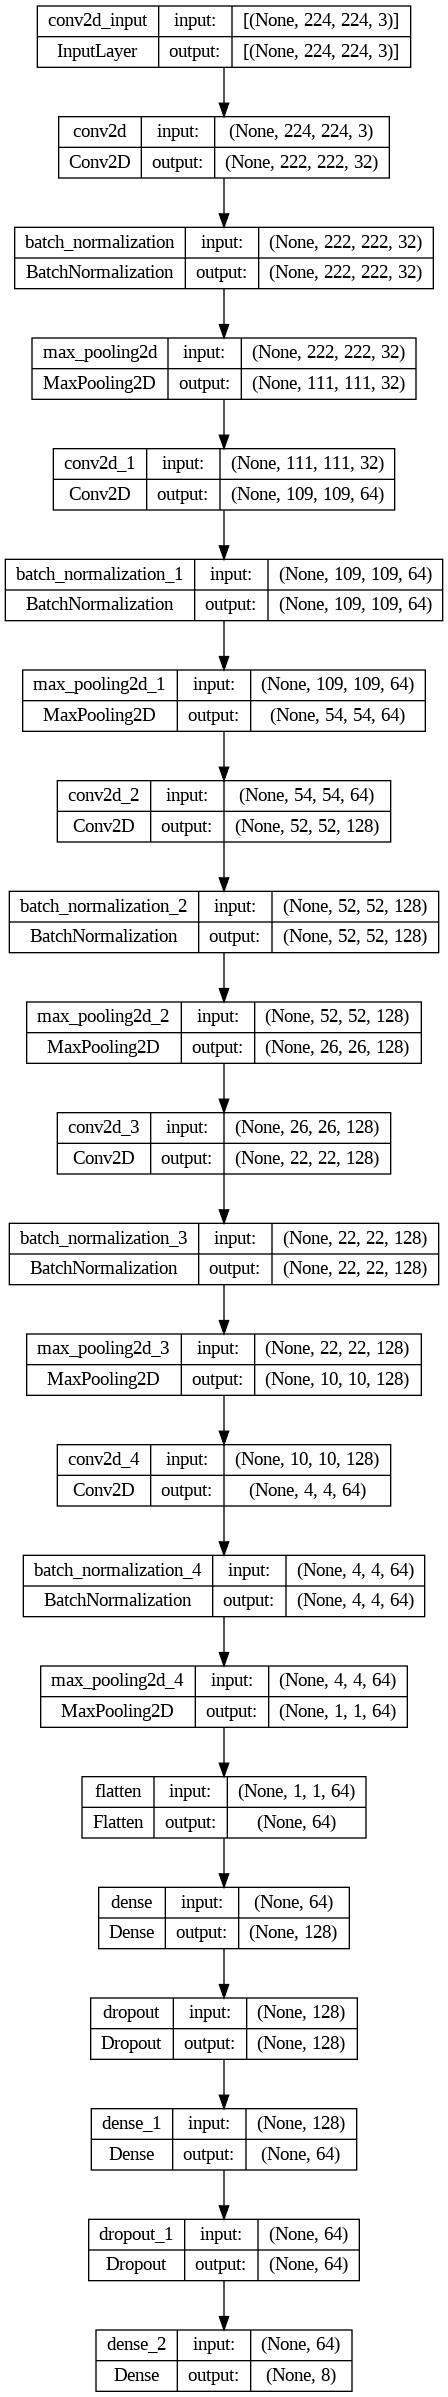

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Model Training

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_ds,epochs=10, validation_data=val_ds)

Epoch 1/10
1439/1439 [==============================] - 694s 466ms/step - loss: 0.9457 - accuracy: 0.6794 - val_loss: 2.0849 - val_accuracy: 0.3438
Epoch 2/10
1439/1439 [==============================] - 665s 460ms/step - loss: 0.7658 - accuracy: 0.7379 - val_loss: 2.1701 - val_accuracy: 0.3613
Epoch 3/10
1439/1439 [==============================] - 662s 459ms/step - loss: 0.7192 - accuracy: 0.7518 - val_loss: 1.9301 - val_accuracy: 0.3928
Epoch 4/10
1439/1439 [==============================] - 664s 460ms/step - loss: 0.6801 - accuracy: 0.7636 - val_loss: 1.9134 - val_accuracy: 0.3973
Epoch 5/10
1439/1439 [==============================] - 664s 460ms/step - loss: 0.6450 - accuracy: 0.7738 - val_loss: 1.9953 - val_accuracy: 0.3696
Epoch 6/10
1439/1439 [==============================] - 663s 459ms/step - loss: 0.6055 - accuracy: 0.7855 - val_loss: 1.9447 - val_accuracy: 0.4364
Epoch 7/10
1439/1439 [==============================] - 663s 459ms/step - loss: 0.5638 - accuracy: 0.7993 - val_

In [ ]:
model.save('/content/drive/MyDrive/Assignment2 data/custom classification' , save_format = 'h5')